# Company Bankruptcy Prediction

## Function

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, f1_score,ConfusionMatrixDisplay,classification_report

def importData(filename):
    """Fungsi untuk import data & hapus duplikat
    :param filename: <string> nama file input (format .csv)
    :return df: <pandas dataframe> sampel data
    """

    # read data
    data = pd.read_csv(filename, sep=";")
    print("Data asli            : ", data.shape, "- (#observasi, #kolom)")

    # drop duplicates
    data = data.drop_duplicates()
    print("Data setelah di-drop : ", data.shape, "- (#observasi, #kolom)")

    return data


def extractInputOutput(data, output_column_name):
    """Fungsi untuk memisahkan data input dan output
    :param df: <pandas dataframe> data seluruh sample
    :param output_column_name: <string> nama kolom output
    :return input_data: <pandas dataframe> data input
    :return output_data: <pandas series> data output
    """
    # drop data
    output_data = data[output_column_name].astype("int")
    input_data = data.drop(output_column_name, axis = 1)

    return input_data, output_data


def extractCategorical(data, categorical_column):
    """
    Fungsi untuk ekstrak data kategorikal dengan One Hot Encoding
    :param data: <pandas dataframe> data sample
    :param categorical_column: <list> list kolom kategorik
    :return categorical_ohe: <pandas dataframe> data sample dengan ohe
    """
    data_categorical = data[categorical_column]
    categorical_ohe = pd.get_dummies(data_categorical)

    return categorical_ohe


def standardizerData(data):
    """
    Fungsi untuk melakukan standarisasi data
    :param data: <pandas dataframe> sampel data
    :return standardized_data: <pandas dataframe> sampel data standard
    :return standardizer: method untuk standardisasi data
    """
    data_columns = data.columns  # agar nama kolom tidak hilang
    data_index = data.index  # agar index tidak hilang

    # buat (fit) standardizer
    standardizer = StandardScaler()
    standardizer.fit(data)

    # transform data
    standardized_data_raw = standardizer.transform(data)
    standardized_data = pd.DataFrame(standardized_data_raw)
    standardized_data.columns = data_columns
    standardized_data.index = data_index

    return standardized_data, standardizer


def extractData(data,
                numerical_column, categorical_column, ohe_column,
                standardizer):
    """
    Fungsi untuk mengekstrak & membersihkan data
    :param data: <pandas dataframe> sampel data
    :param numerical_column: <list> kolom numerik
    :param categorical_column: <list> kolom kategorik
    :param ohe_column: <list> kolom one-hot-encoding dari data kategorik
    :param standardizer: <sklearn method> standardizer data
    :return cleaned_data: <pandas dataframe> data final
    """
    # Filter data
    numerical_data = data[numerical_column]
    categorical_data = data[categorical_column]

    # Proses data numerik
    numerical_data.columns = numerical_column
    numerical_data.index = data.index

    # Proses data kategorik
    categorical_data = categorical_data.fillna(value="KOSONG")
    categorical_data.index = data.index
    categorical_data = pd.get_dummies(categorical_data)
    categorical_data.reindex(index = categorical_data.index,
                             columns = ohe_column)

    # Gabungkan data
    concat_data = pd.concat([numerical_data, categorical_data],
                             axis = 1)
    cleaned_data = pd.DataFrame(standardizer.transform(concat_data))
    cleaned_data.columns = concat_data.columns

    return cleaned_data


class Model:
    """
    Class untuk menyimpan data-data performa setiap model yang dibuat.
    """
    def __init__(self, y_pred):
        """
        Fungsi inisialisasi untuk menyimpan performa model.
        :param y_pred: <pandas dataframe> output y hasil prediksi model
        """
        self.accuracy = 0
        self.precision = 0
        self.recall = 0
        self.f1 = 0
        self.y_pred = y_pred
        self.auc = 0

    def checkAccuracy(self, y_true):
        """
        Fungsi untuk menghitung akurasi hasil prediksi jika dibandingkan dengan output seharusnya.
        :param y_true: <pandas dataframe> output yang seharusnya
        :param y_pred: <pandas datafram> output hasil prediksi
        """

        # Visualisasi Confusion Matrix
        confusion_matrix = metrics.confusion_matrix(y_true, self.y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
        cm_display.plot()
        plt.xlabel("Prediction")
        plt.ylabel("Actual")
        plt.show()

        # Menghitung akurasi
        self.accuracy = np.round(accuracy_score(y_true, self.y_pred),2)
        self.precision = np.round(precision_score(y_true, self.y_pred),2)
        self.recall = np.round(recall_score(y_true, self.y_pred),2)
        self.f1 = np.round(f1_score(y_true, self.y_pred),2)

        # Menampilkan akurasi
        print("Accuracy:", self.accuracy)
        print("Precision:", self.precision)
        print("Recall:", self.recall)
        print("F1 score:", self.f1)

        return


    def printAccuracy(self):
        """
        Fungsi untuk menampilkan seluruh data performa model.
        """
        print("Accuracy:", self.accuracy)
        print("Precision:", self.precision)
        print("Recall:", self.recall)
        print("F1 score:", self.f1)
        print("AUC:", self.auc)


    def plotROC(self, y_true):
        """
        Fungsi untuk menampilkan visualisasi ROC Curve.
        :param y_true: output y yang seharusnya
        """
        fpr, tpr, thresholds = roc_curve(y_true, self.y_pred)
        self.auc = np.round(roc_auc_score(y_true, self.y_pred),2)

        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % self.auc)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate (Recall)')
        plt.title('ROC Curve with AUC')
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.show()

# Exploratory Data Analysis

In [ ]:
# load dataset
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
df = pd.read_csv('data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


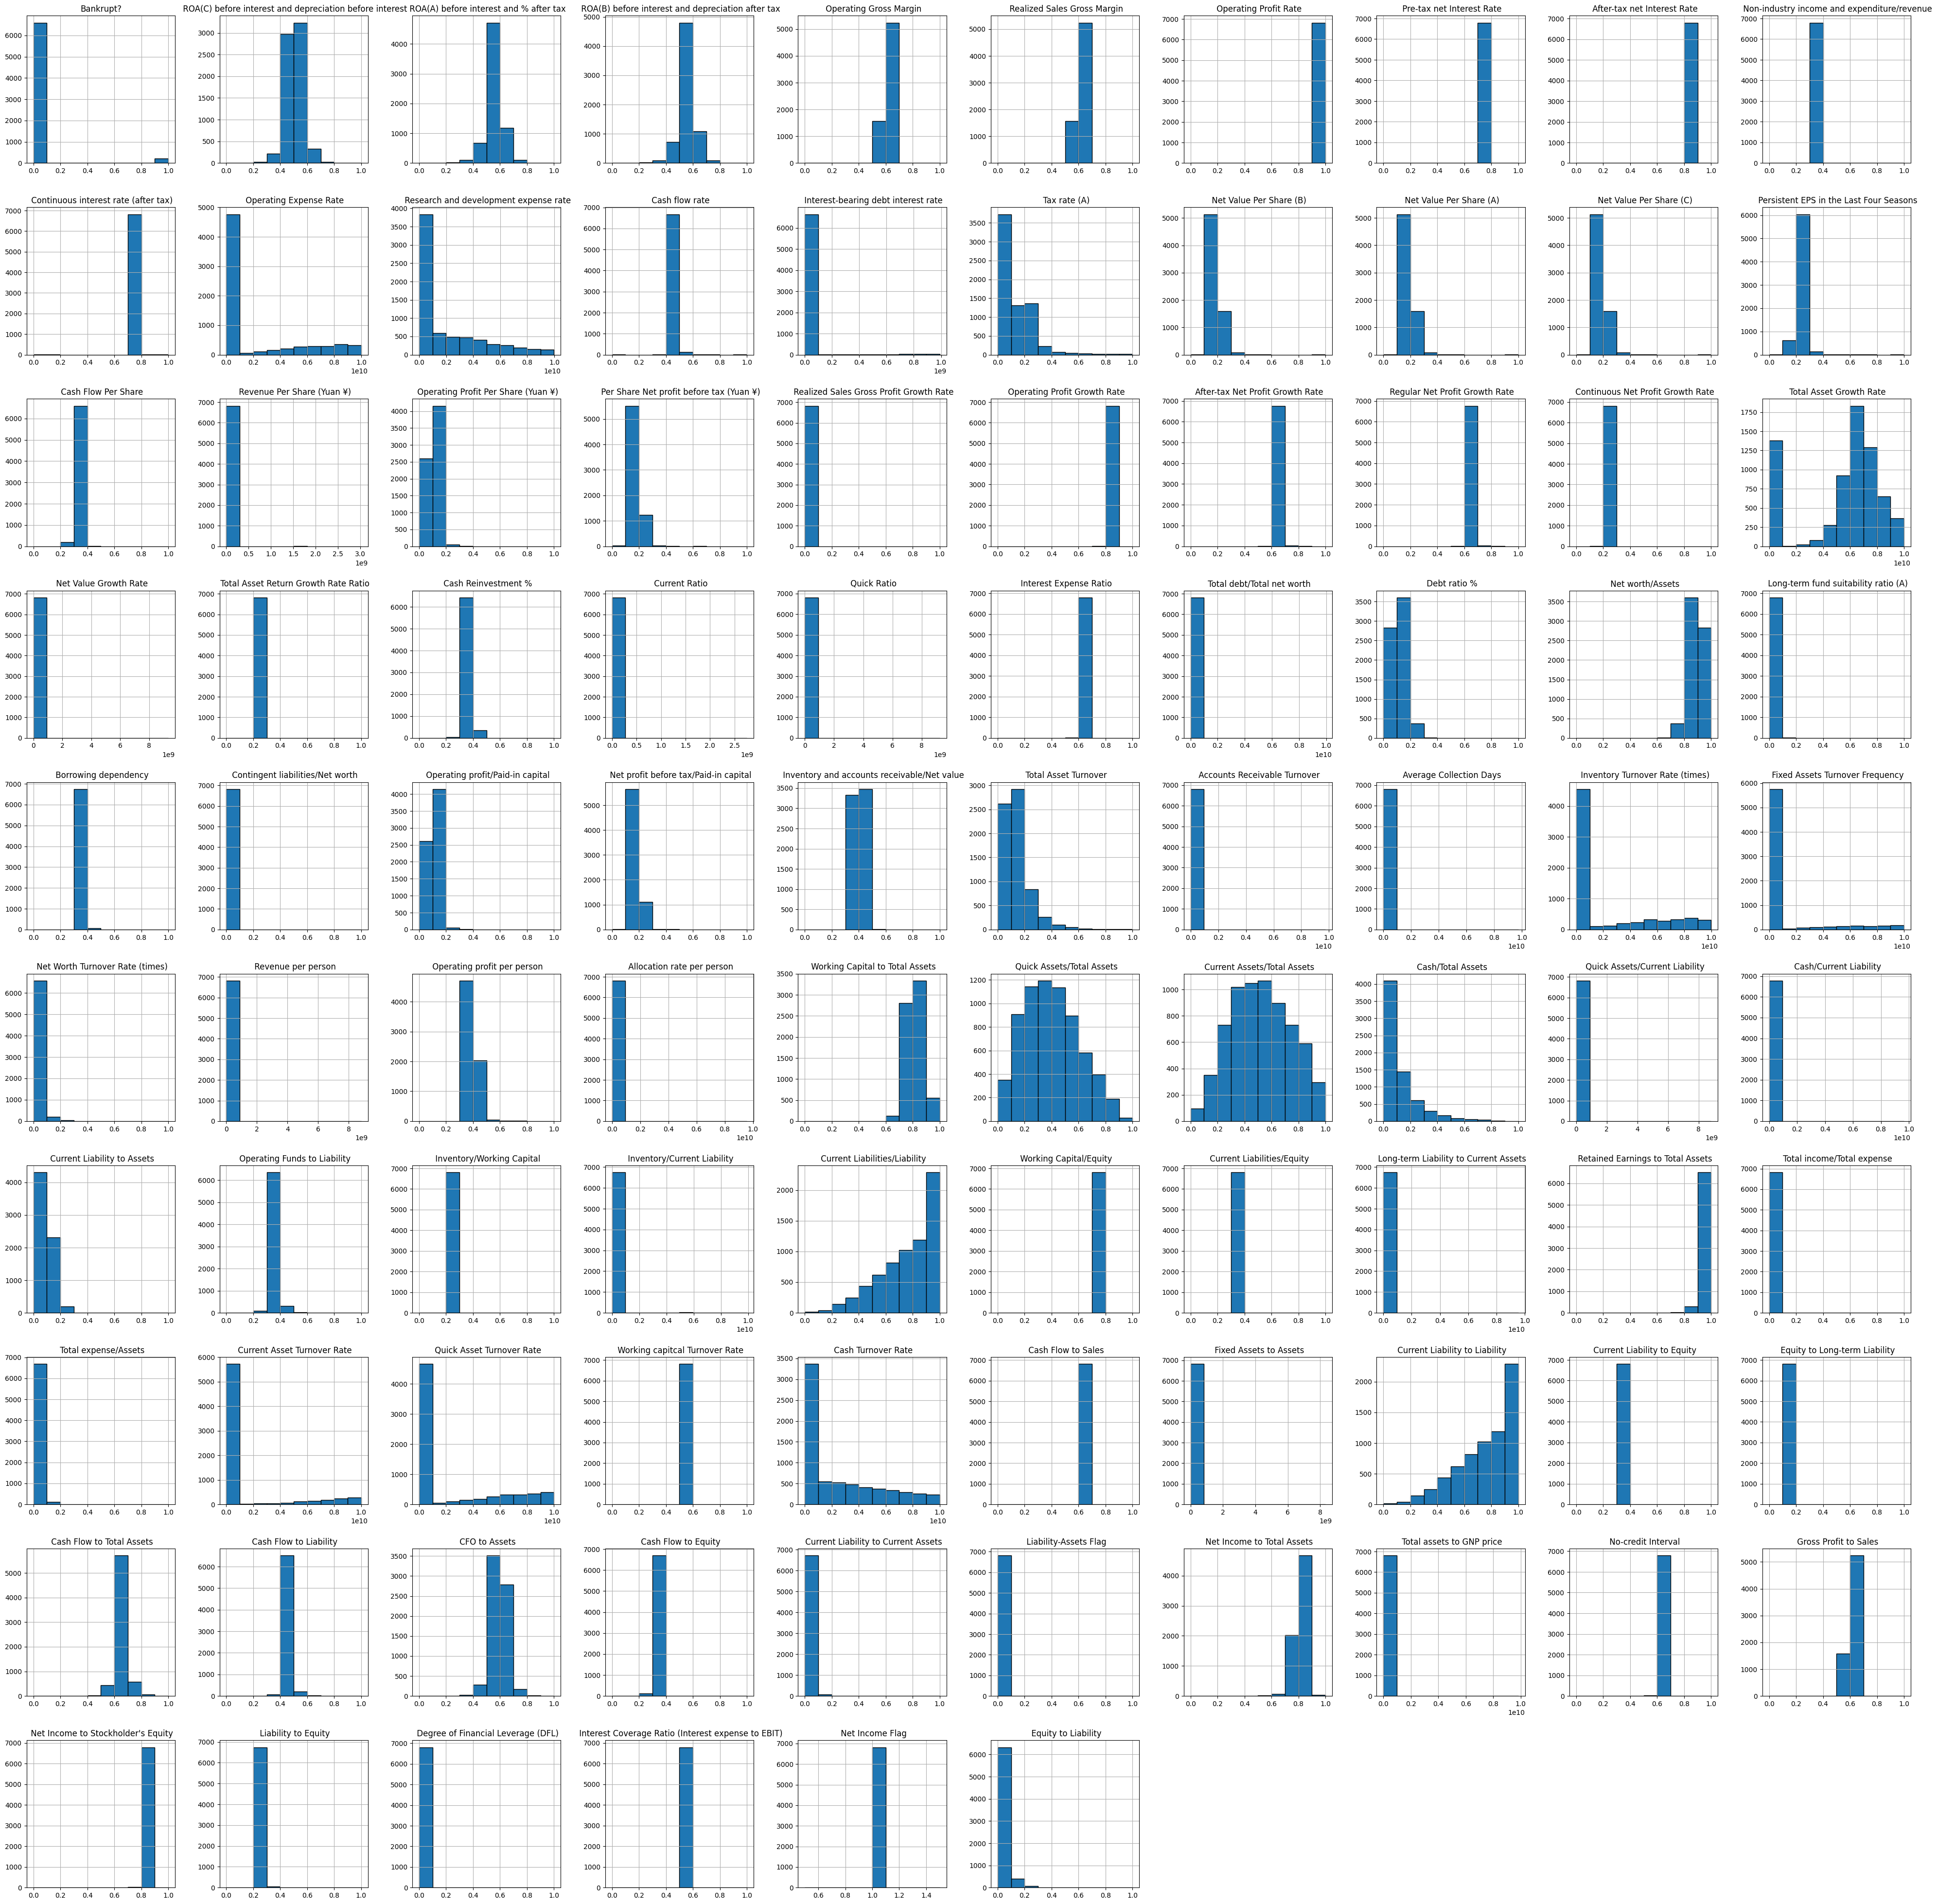

In [ ]:
# check absence of predictors

df.hist(figsize=(50,50), edgecolor='black')
plt.show()

In [ ]:
# check data type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

Tipe data sudah benar.

In [ ]:
# check missing data, nans and outlier

df.isna().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

Tidak ada missing value.

In [ ]:
# check data range

df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [ ]:
# check the shape of the dataset
df.shape

(6819, 96)

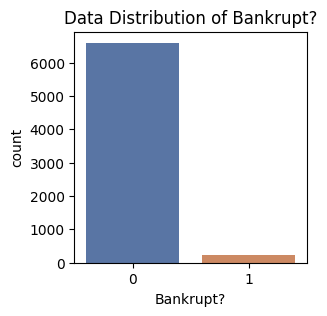

In [ ]:
# check imbalance data

plt.figure(figsize=(3,3))
sns.countplot(x=df["Bankrupt?"], palette="deep")
plt.title("Data Distribution of Bankrupt?")
plt.show()

In this observation, it is evident that the majority of the data falls under class 0, indicating an imbalance in the dataset.

In [ ]:
# check imbalance ratio

majority_class_samples=df["Bankrupt?"].loc[df["Bankrupt?"]==0]
minority_class_samples=df["Bankrupt?"].loc[df["Bankrupt?"]==1]
Imbalance_Ratio= len(majority_class_samples)/len(minority_class_samples)
print(f"Imbalance Ratio is:{Imbalance_Ratio}")

Imbalance Ratio is:29.995454545454546


# PERCOBAAN 1: Pemodelan dengan Data Imbalance


# Data Preprocessing

## Mengidentifikasi kolom kategorikal dan numerik

In [ ]:
def get_num_cat_columns(dataframe):
    categorical_cols=dataframe.select_dtypes(include="object").columns
    numerical_cols=dataframe.select_dtypes(exclude="object").columns

    return categorical_cols, numerical_cols

In [ ]:
df = df.rename(columns={'Bankrupt?': 'y'})
df.head()

,y,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## Memisahkan Data Train dan Data Test

In [ ]:
# Train test split
data_train, data_test = train_test_split(df, test_size = 0.20, random_state = 12)

# Ratio check (harus sama dengan test_size)
print("Ratio:", data_test.shape[0] / df.shape[0])
print("Dimensi data train:", data_train.shape)
print("Dimensi data test:", data_test.shape)

Ratio: 0.20002932981375568
Dimensi data train: (5455, 96)
Dimensi data test: (1364, 96)


In [ ]:
# Meng-export data_train ke dalam excel (untuk Exploratory Data Analysis via Tableau)
data_train.to_excel("data_train.xlsx", index=False)

## Memisahkan Input dan Output

In [ ]:
# Memisahkan input dan output
x_train, y_train = extractInputOutput(data_train, "y")
x_test, y_test = extractInputOutput(data_test, "y")

# Sanity check hasil splitting
print("Data training:", x_train.shape, y_train.shape)
print("Data test:", x_test.shape, y_test.shape)

x_train.head()

Data training: (5455, 95) (5455,)
Data test: (1364, 95) (1364,)


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
3477,0.537708,0.600523,0.591788,0.621081,0.621081,0.999138,0.797587,0.809490,0.303517,0.781758,...,0.837468,0.001849,0.624107,0.621082,0.842400,0.276259,0.026792,0.565164,1,0.071587
3538,0.516843,0.522460,0.557150,0.597645,0.597645,0.998948,0.797357,0.809285,0.303512,0.781545,...,0.791424,0.000348,0.623370,0.597642,0.839654,0.280364,0.026590,0.563973,1,0.027268
6702,0.488422,0.554623,0.537074,0.597284,0.597284,0.998998,0.797429,0.809341,0.303533,0.781600,...,0.807069,0.002985,0.624714,0.597283,0.841042,0.281041,0.027117,0.566345,1,0.025453
6563,0.562765,0.611044,0.594893,0.623135,0.623135,0.999146,0.797597,0.809456,0.303516,0.781725,...,0.836814,0.000322,0.624059,0.623133,0.842406,0.276409,0.026791,0.565158,1,0.066263
2164,0.441086,0.506542,0.490658,0.594503,0.594503,0.998778,0.797164,0.809099,0.303530,0.781340,...,0.777825,0.007743,0.622825,0.594497,0.838248,0.282322,0.026586,0.563947,1,0.022902


In [ ]:
def train_test_split_data(df,target,test_size, random_state):
    x_train,x_test, y_train, y_test= train_test_split(df.drop([target], axis=1),
                                                      df[target],
                                                      test_size=test_size,
                                                      random_state=random_state,
                                                      stratify=df[target]
                                                      )

    return x_train,x_test, y_train, y_test

In [ ]:
x_train,x_test, y_train, y_test= train_test_split_data(df,target="y",test_size=0.3, random_state=42)

In [ ]:
x_train.shape,x_test.shape, y_train.shape, y_test.shape

((4773, 95), (2046, 95), (4773,), (2046,))

In [ ]:
categorical_cols, numerical_cols= get_num_cat_columns(x_train)

In [ ]:
def Winsorization_Method(columns, x_train, y_train , a, b):
    outliers=[]

    for col in columns:
        q1= np.percentile(x_train[col], a)
        q2= np.percentile(x_train[col],b)

        for pos in range(len(x_train)):
            if x_train[col].iloc[pos]>q2 or x_train[col].iloc[pos]<q1:
                outliers.append(pos)

    outliers= set(outliers)                   # remove the duplicates from the outliers
    outliers= list(outliers)

    ratio= round(len(outliers)/len(x_train)*100, 2)                       # Ratio of outliers
    x_train.drop(x_train.index[outliers], inplace=True)    # remove the outliers from the training dataset
    y_train.drop(y_train.index[outliers], inplace=True)



    return ratio, x_train, y_train

In [ ]:
ratio, x_train, y_train= Winsorization_Method(numerical_cols, x_train, y_train,a=0.3,b=99.7)

In [ ]:
print(f"Ratio of Outliers Detected in the dataset:{ratio}")

Ratio of Outliers Detected in the dataset:19.86


In [ ]:
# shape of data after removing the outliers in the training data
x_train.shape, y_train.shape

((3825, 95), (3825,))

## Data Preprocessing

In [ ]:
scaler= RobustScaler()
x_train_processed= scaler.fit_transform(x_train)
x_test_processed=scaler.transform(x_test)

## Perform the Principle Component Analysis to select the features that has high impact on the Target Variable (Bankrupt)

In [ ]:
pca= PCA(n_components=70)
x_train_pca= pca.fit_transform(x_train_processed)
x_test_pca=pca.transform(x_test_processed)

In [ ]:
x_train_pca.shape, y_train.shape, x_test_pca.shape, y_test.shape

((3825, 70), (3825,), (2046, 70), (2046,))

In [ ]:
# Most important features
print(f"No. of Components Used:{pca.n_components_}")

No. of Components Used:70


In [ ]:
# The amount of variance explained by each of the selected components.
print(f"Variance:{pca.explained_variance_}")

Variance:[2.36523012e+26 1.21129854e+24 9.16918619e+22 2.36485435e+21
 1.67231325e+21 2.17817346e+20 1.82757368e+02 9.45011247e+01
 5.85878080e+01 2.64478044e+01 2.35781469e+01 1.94415950e+01
 1.64105362e+01 1.61746911e+01 1.36585924e+01 1.29128112e+01
 1.06698462e+01 1.03132628e+01 9.13806292e+00 7.15521572e+00
 6.36957449e+00 4.85895252e+00 4.26087441e+00 3.84888409e+00
 3.76187380e+00 3.11842780e+00 2.69978066e+00 2.24365482e+00
 2.06248201e+00 1.61869711e+00 1.52483759e+00 1.34947653e+00
 1.26288023e+00 1.16579719e+00 1.11295988e+00 9.46081098e-01
 8.56198767e-01 7.48180747e-01 6.39746607e-01 5.89037984e-01
 5.55281285e-01 5.51228791e-01 5.14570065e-01 5.06534034e-01
 4.72102950e-01 4.39162883e-01 4.00997693e-01 3.58772423e-01
 3.39165258e-01 3.12503821e-01 2.87110125e-01 2.69009700e-01
 2.57917895e-01 2.37708241e-01 2.20105188e-01 1.90690148e-01
 1.73433883e-01 1.39834725e-01 1.15206673e-01 1.12015280e-01
 1.01434710e-01 8.56182280e-02 7.54711361e-02 6.44227596e-02
 5.94559376e-02

In [ ]:
# Percentage of variance explained by each of the selected components.
print(f"Variance_Ratio:{pca.explained_variance_ratio_}")

Variance_Ratio:[9.94503452e-01 5.09312210e-03 3.85534889e-04 9.94345454e-06
 7.03154118e-06 9.15852123e-07 7.68436155e-25 3.97346939e-25
 2.46342954e-25 1.11204540e-25 9.91385504e-26 8.17456752e-26
 6.90010448e-26 6.80093918e-26 5.74300029e-26 5.42942324e-26
 4.48632834e-26 4.33639643e-26 3.84226256e-26 3.00853887e-26
 2.67820191e-26 2.04303379e-26 1.79156112e-26 1.61833239e-26
 1.58174735e-26 1.31119894e-26 1.13517123e-26 9.43384935e-27
 8.67207576e-27 6.80610249e-27 6.41145329e-27 5.67411628e-27
 5.31000659e-27 4.90180351e-27 4.67963955e-27 3.97796777e-27
 3.60004138e-27 3.14586023e-27 2.68992943e-27 2.47671592e-27
 2.33477982e-27 2.31774038e-27 2.16360219e-27 2.12981326e-27
 1.98504158e-27 1.84653916e-27 1.68606677e-27 1.50852304e-27
 1.42608120e-27 1.31397840e-27 1.20720605e-27 1.13109956e-27
 1.08446208e-27 9.99486960e-28 9.25471767e-28 8.01790951e-28
 7.29233887e-28 5.87960198e-28 4.84407133e-28 4.70988350e-28
 4.26500442e-28 3.59997206e-28 3.17331937e-28 2.70877055e-28
 2.499931

Lets Balance the dataset using SMOTE Oversampling Technique

SMOTE should only be used to augment training data. Your test dataset should remain untouched. Applying SMOTE to the entire dataset will result in data leakage.

In [ ]:
smote= SMOTE(sampling_strategy='minority', random_state=43)
x_train_smote, y_train_smote= smote.fit_resample(x_train_pca, y_train)

# Modelling

## Baseline

Baseline diambil dari proporsi kelas target yang terbesar.
Dengan kata lain, menebak hasil output marketing response dengan nilai "no" semua tanpa modeling.

In [ ]:
y_train.value_counts(normalize = True)

0    0.977255
1    0.022745
Name: y, dtype: float64

Maka, baseline data training adalah 97%.

In [ ]:
y_test.value_counts(normalize = True)

0    0.967742
1    0.032258
Name: y, dtype: float64

Maka, baseline data test adalah 96%.

## 4.2. Fitting Model

In [ ]:
# Model K-Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
# Model Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state = 123, class_weight='balanced')
logreg.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=123)

In [ ]:
# Model Random Forest
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state = 1234, n_estimators = 30)
random_forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=30, random_state=1234)

In [ ]:
# Model Decision Tree
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=1234)
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=1234)

In [ ]:
x_test.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
4893,0.525764,0.596326,0.581134,0.599050,0.599230,0.999005,0.797614,0.809517,0.303841,0.781787,...,0.833515,0.015227,0.625343,0.599048,0.842254,0.276560,0.026792,0.565164,1,0.061746
1462,0.617413,0.663650,0.649660,0.613932,0.611338,0.999100,0.798676,0.810280,0.305499,0.782612,...,0.852714,0.002913,0.625007,0.613930,0.843495,0.276838,0.026799,0.565195,1,0.055117
1645,0.551748,0.612516,0.600086,0.603475,0.603475,0.999067,0.797505,0.809412,0.303521,0.781678,...,0.832809,0.021061,0.624736,0.603472,0.843393,0.281172,0.026868,0.565500,1,0.025146
1512,0.465753,0.530037,0.518979,0.624079,0.624079,0.999046,0.797294,0.809253,0.303196,0.781508,...,0.788457,0.000904,0.623863,0.624078,0.839335,0.281632,0.025908,0.539606,1,0.024158
3966,0.527519,0.533199,0.568392,0.599857,0.599857,0.998960,0.797386,0.809313,0.303538,0.781574,...,0.796627,0.004723,0.623637,0.599854,0.840084,0.277441,0.028609,0.568345,1,0.045304


Misal kita gunakan 3 model ML untuk klasifikasi:
- K-nearest neighbor (K-NN)
- Logistic Regression
- Random Forest

## 4.4. Evaluasi Model di Data Training dan Data Test

### a. Evaluasi Model K-Nearest Neighbor

Akurasi KNN di Data Training:


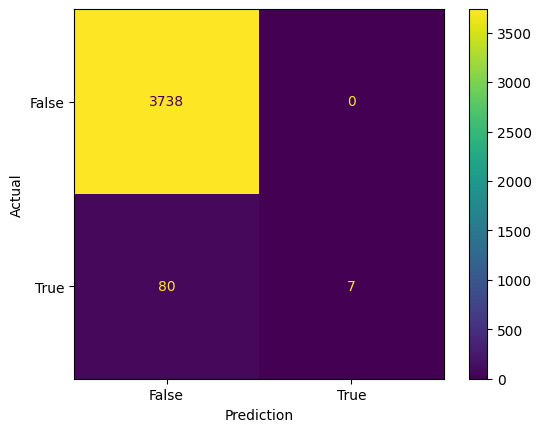

Accuracy: 0.98
Precision: 1.0
Recall: 0.08
F1 score: 0.15

Akurasi KNN di Data Test:


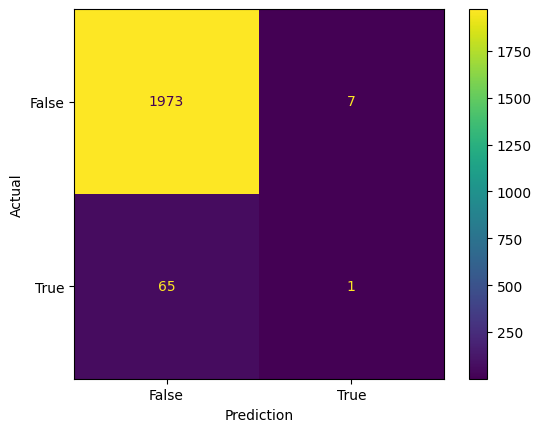

Accuracy: 0.96
Precision: 0.12
Recall: 0.02
F1 score: 0.03


In [ ]:
# Prediksi KNN di data train
y_train_pred_knn = pd.DataFrame(knn.predict(x_train))

# Prediksi KNN di data test
y_test_pred_knn = pd.DataFrame(knn.predict(x_test))

# Cek akurasi
print("Akurasi KNN di Data Training:")
knn_train = Model(y_train_pred_knn)
knn_train.checkAccuracy(y_train)
print("")
print("Akurasi KNN di Data Test:")
knn_test = Model(y_test_pred_knn)
knn_test.checkAccuracy(y_test)

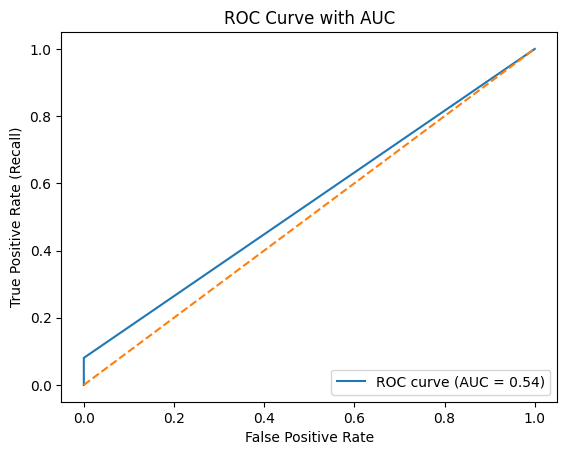

In [ ]:
knn_train.plotROC(y_train)

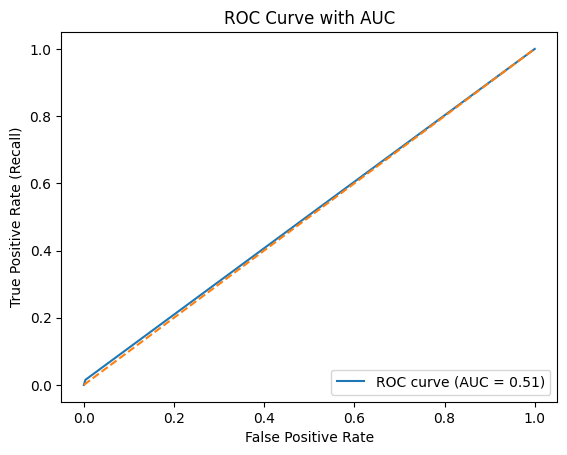

In [ ]:
knn_test.plotROC(y_test)

### b. Evaluasi Model Logistic Regression

Akurasi LogReg di Data Training:


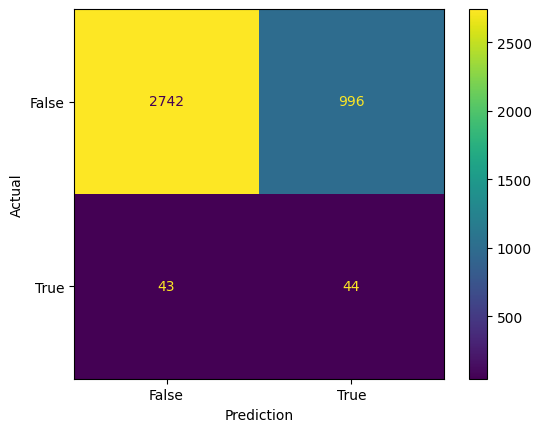

Accuracy: 0.73
Precision: 0.04
Recall: 0.51
F1 score: 0.08

Akurasi LogReg di Data Test:


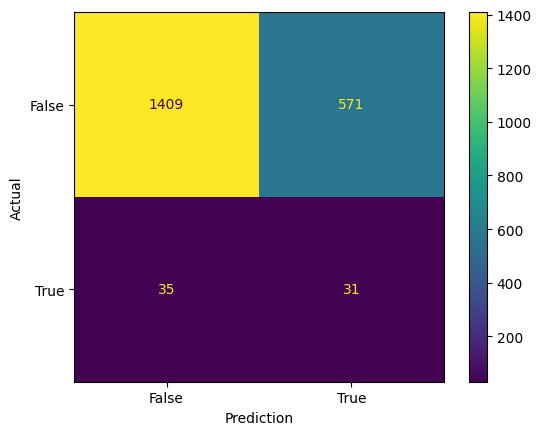

Accuracy: 0.7
Precision: 0.05
Recall: 0.47
F1 score: 0.09


In [ ]:
# Prediksi LogReg di data training
y_train_pred_logreg = pd.DataFrame(logreg.predict(x_train))

# Prediksi LogReg di data test
y_test_pred_logreg = pd.DataFrame(logreg.predict(x_test))

# Cek akurasi
print("Akurasi LogReg di Data Training:")
logreg_train = Model(y_train_pred_logreg)
logreg_train.checkAccuracy(y_train)

print("")
print("Akurasi LogReg di Data Test:")
logreg_test = Model(y_test_pred_logreg)
logreg_test.checkAccuracy(y_test)

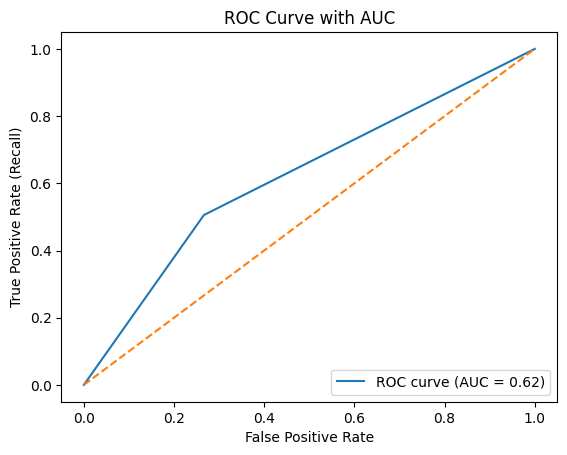

In [ ]:
logreg_train.plotROC(y_train)

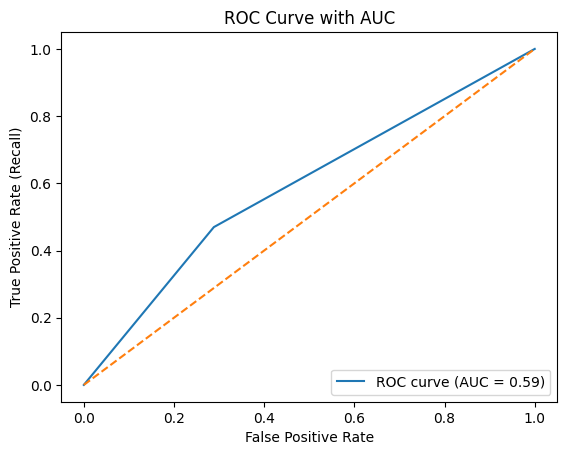

In [ ]:
logreg_test.plotROC(y_test)

### c. Evaluasi Model Random Forest

Akurasi RF di Data Training:


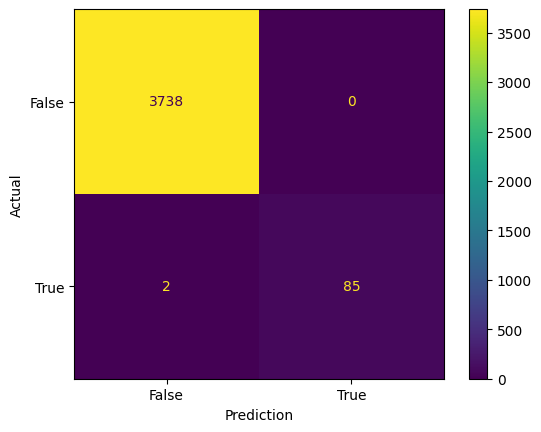

Accuracy: 1.0
Precision: 1.0
Recall: 0.98
F1 score: 0.99

Akurasi RF di Data Test:


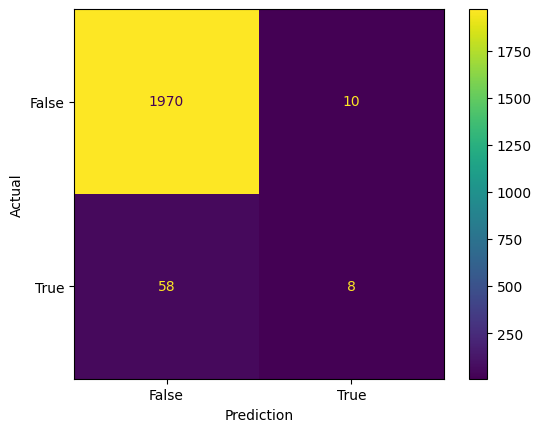

Accuracy: 0.97
Precision: 0.44
Recall: 0.12
F1 score: 0.19


In [ ]:
# Prediksi Random Forest di data training
y_train_pred_rf = pd.DataFrame(random_forest.predict(x_train))

# Prediksi Random Forest di data test
y_test_pred_rf = pd.DataFrame(random_forest.predict(x_test))

# Cek akurasi
print("Akurasi RF di Data Training:")
rf_train = Model(y_train_pred_rf)
rf_train.checkAccuracy(y_train)

print("")
print("Akurasi RF di Data Test:")
rf_test = Model(y_test_pred_rf)
rf_test.checkAccuracy(y_test)

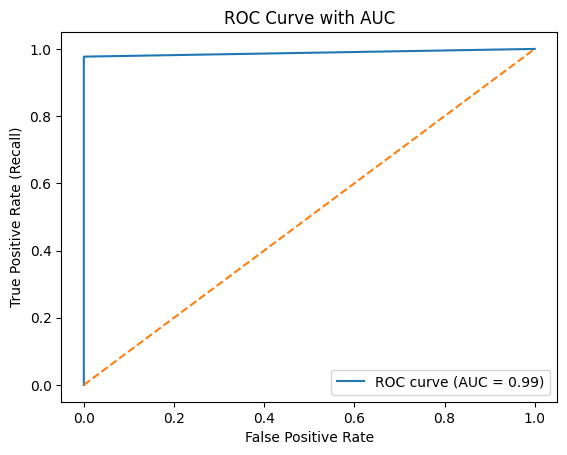

In [ ]:
rf_train.plotROC(y_train)

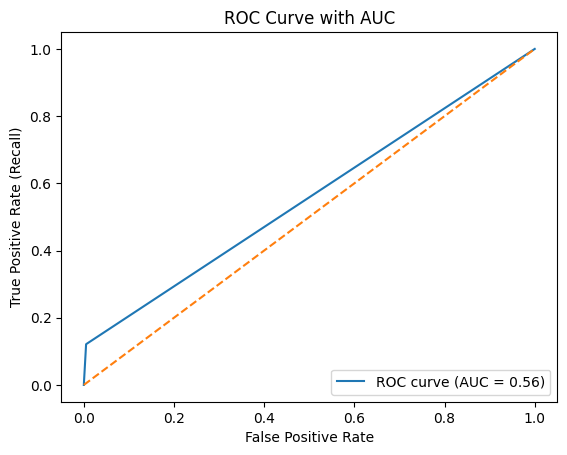

In [ ]:
rf_test.plotROC(y_test)

# PERCOBAAN 2: Oversample Data Imbalance

# 5. Data Augmentation
## 5.1. Cek Imbalance

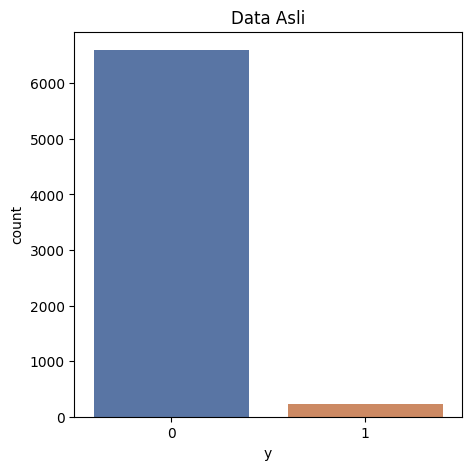

In [ ]:
# Cek imbalance di data asli
plt.figure(figsize=(5,5))
sns.countplot(x=df["y"], palette="deep")
plt.title("Data Asli")
plt.show()

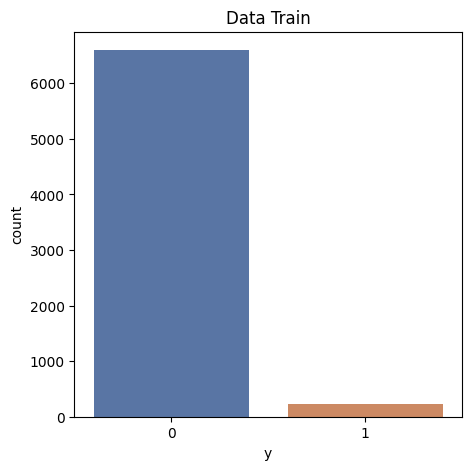

In [ ]:
# Cek imbalance di data train
plt.figure(figsize=(5,5))
sns.countplot(x=df["y"], palette="deep")
plt.title("Data Train")
plt.show()

Imbalance di data train sama dengan di data asli.

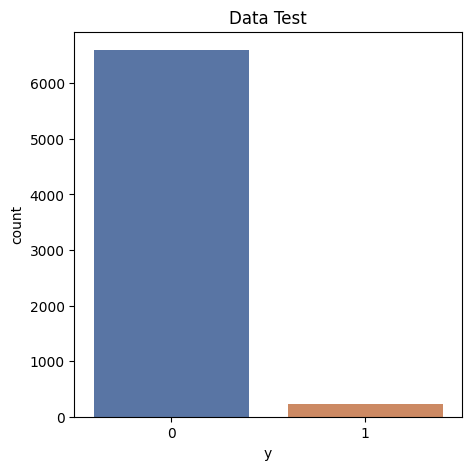

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x=df["y"], palette="deep")
plt.title("Data Test")
plt.show()

Imbalance di data train sama dengan di data asli.

## 5.2. Data Augmentation dengan SMOTE

In [ ]:
data_train.head()

,y,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
3477,0,0.537708,0.600523,0.591788,0.621081,0.621081,0.999138,0.797587,0.809490,0.303517,...,0.837468,0.001849,0.624107,0.621082,0.842400,0.276259,0.026792,0.565164,1,0.071587
3538,0,0.516843,0.522460,0.557150,0.597645,0.597645,0.998948,0.797357,0.809285,0.303512,...,0.791424,0.000348,0.623370,0.597642,0.839654,0.280364,0.026590,0.563973,1,0.027268
6702,0,0.488422,0.554623,0.537074,0.597284,0.597284,0.998998,0.797429,0.809341,0.303533,...,0.807069,0.002985,0.624714,0.597283,0.841042,0.281041,0.027117,0.566345,1,0.025453
6563,0,0.562765,0.611044,0.594893,0.623135,0.623135,0.999146,0.797597,0.809456,0.303516,...,0.836814,0.000322,0.624059,0.623133,0.842406,0.276409,0.026791,0.565158,1,0.066263
2164,0,0.441086,0.506542,0.490658,0.594503,0.594503,0.998778,0.797164,0.809099,0.303530,...,0.777825,0.007743,0.622825,0.594497,0.838248,0.282322,0.026586,0.563947,1,0.022902


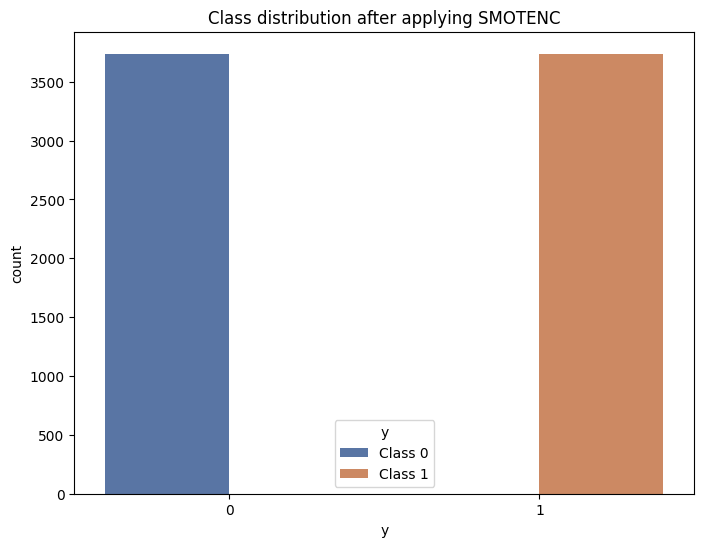

In [ ]:
# Data augmentation dengan SMOTENC supaya balance
from imblearn.over_sampling import SMOTENC
sm = SMOTENC([1,2,3,5,6,9], random_state=123)
x_resampled, y_resampled = sm.fit_resample(x_train, y_train)

plt.figure(figsize=(8,6))
sns.countplot(x=y_resampled, palette="deep", hue=y_resampled)
plt.title("Class distribution after applying SMOTENC")
plt.legend(title='y', labels=['Class 0', 'Class 1'])
plt.show()

# 6. Fitting Model dengan Data Resampled

Misal kita gunakan 3 model ML untuk klasifikasi:
- K-nearest neighbor (K-NN)
- Logistic Regression
- Random Forest

### a. Model K-Nearest Neighbor

In [ ]:
# Model K-Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_resampled, y_resampled)

KNeighborsClassifier(n_neighbors=3)

### b. Model Logistic Regression

In [ ]:
# Model Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state = 123, class_weight="balanced")
logreg.fit(x_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=123)

### c. Model Random Forest

In [ ]:
# Model Random Forest
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state = 1234, n_estimators = 30)
random_forest.fit(x_resampled, y_resampled)

RandomForestClassifier(n_estimators=30, random_state=1234)

## 7. Evaluasi Model di Data Train Resampled dan Data Test

### a. Evaluasi Model K-Nearest Neighbor

Akurasi KNN di Data Training:


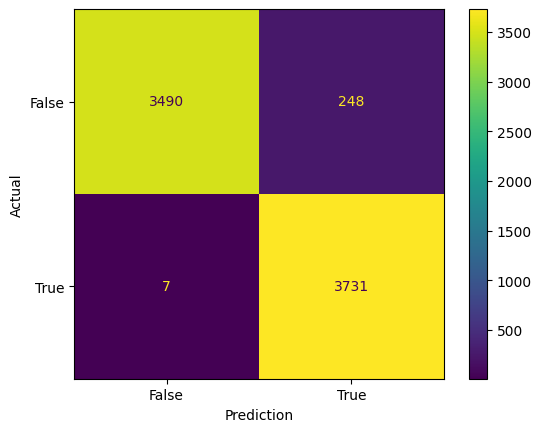

Accuracy: 0.97
Precision: 0.94
Recall: 1.0
F1 score: 0.97

Akurasi KNN di Data Test:


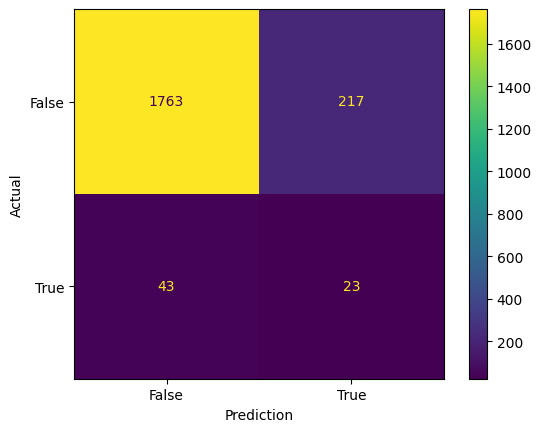

Accuracy: 0.87
Precision: 0.1
Recall: 0.35
F1 score: 0.15


In [ ]:
# Prediksi KNN di data train
y_restrain_pred_knn = pd.DataFrame(knn.predict(x_resampled))

# Prediksi KNN di data test
y_restest_pred_knn = pd.DataFrame(knn.predict(x_test))

# Cek akurasi
print("Akurasi KNN di Data Training:")
knn_restrain = Model(y_restrain_pred_knn)
knn_restrain.checkAccuracy(y_resampled)
print("")
print("Akurasi KNN di Data Test:")
knn_restest = Model(y_restest_pred_knn)
knn_restest.checkAccuracy(y_test)

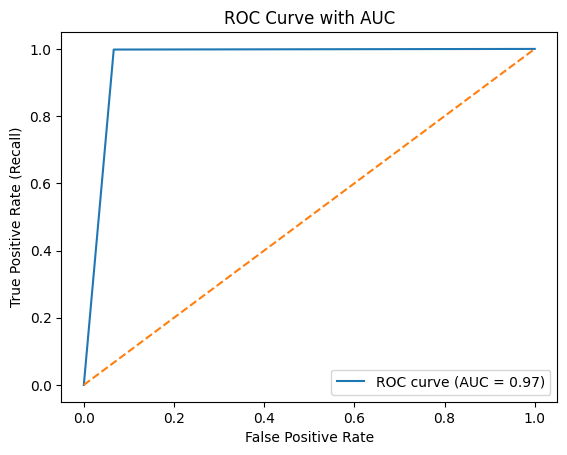

In [ ]:
knn_restrain.plotROC(y_resampled)

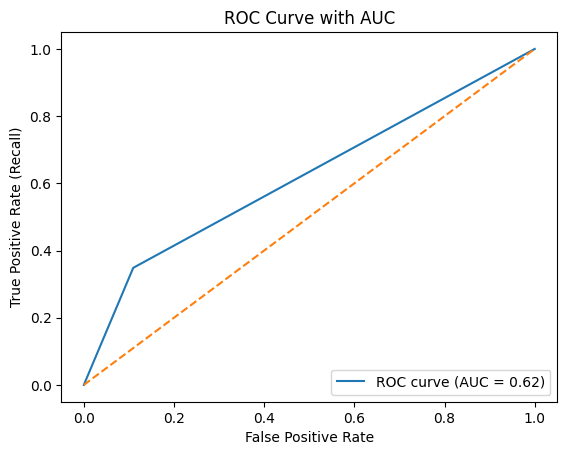

In [ ]:
knn_restest.plotROC(y_test)

### b. Evaluasi Model Logistic Regression

Akurasi LogReg di Data Training:


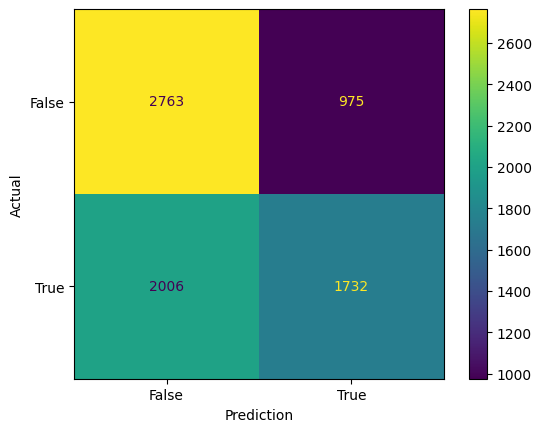

Accuracy: 0.6
Precision: 0.64
Recall: 0.46
F1 score: 0.54

Akurasi LogReg di Data Test:


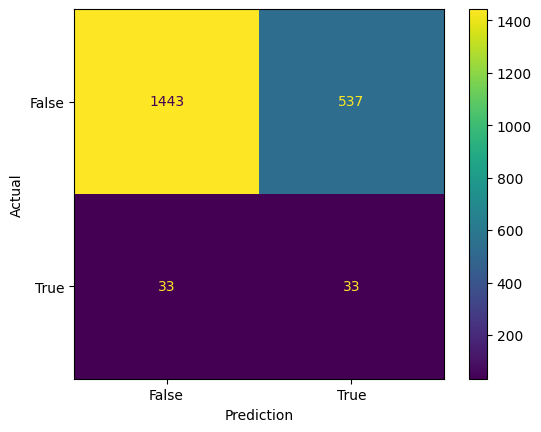

Accuracy: 0.72
Precision: 0.06
Recall: 0.5
F1 score: 0.1


In [ ]:
# Prediksi LogReg di data training
y_restrain_pred_logreg = pd.DataFrame(logreg.predict(x_resampled))

# Prediksi LogReg di data test
y_restest_pred_logreg = pd.DataFrame(logreg.predict(x_test))

# Cek akurasi
print("Akurasi LogReg di Data Training:")
logreg_restrain = Model(y_restrain_pred_logreg)
logreg_restrain.checkAccuracy(y_resampled)

print("")
print("Akurasi LogReg di Data Test:")
logreg_restest = Model(y_restest_pred_logreg)
logreg_restest.checkAccuracy(y_test)

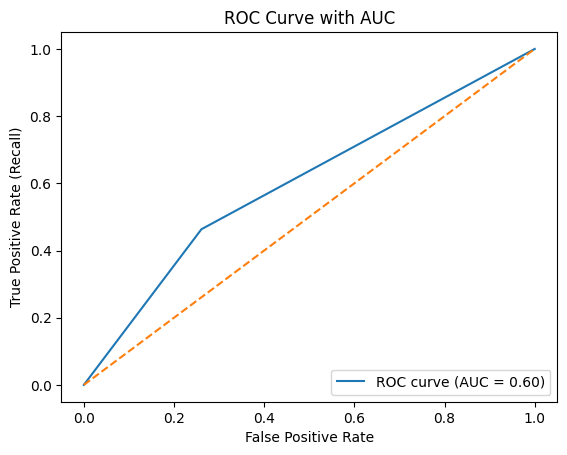

In [ ]:
logreg_restrain.plotROC(y_resampled)

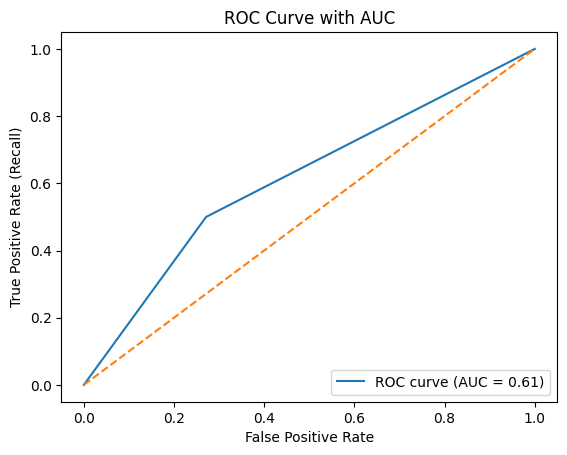

In [ ]:
logreg_restest.plotROC(y_test)

### c. Evaluasi Model Random Forest

Akurasi RF di Data Training:


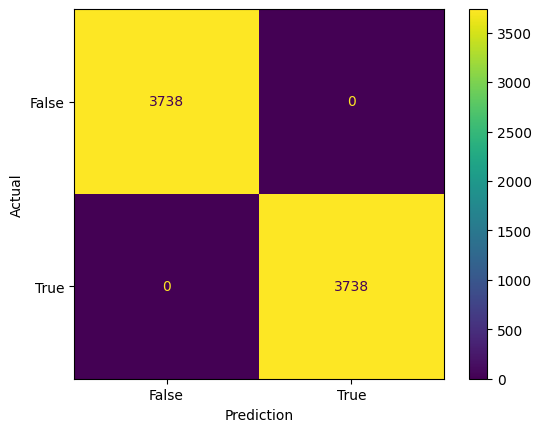

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0

Akurasi RF di Data Test:


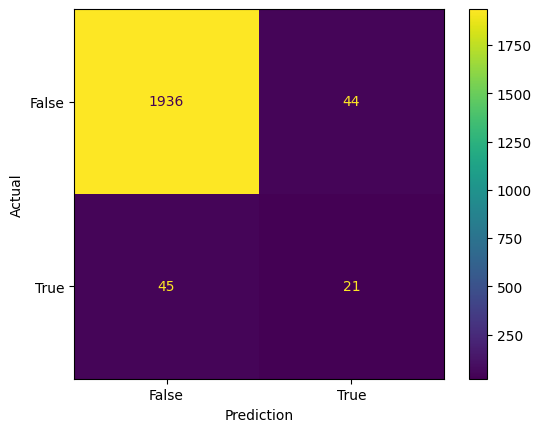

Accuracy: 0.96
Precision: 0.32
Recall: 0.32
F1 score: 0.32


In [ ]:
# Prediksi Random Forest di data training
y_restrain_pred_rf = pd.DataFrame(random_forest.predict(x_resampled))

# Prediksi Random Forest di data test
y_restest_pred_rf = pd.DataFrame(random_forest.predict(x_test))

# Cek akurasi
print("Akurasi RF di Data Training:")
rf_restrain = Model(y_restrain_pred_rf)
rf_restrain.checkAccuracy(y_resampled)

print("")
print("Akurasi RF di Data Test:")
rf_restest = Model(y_restest_pred_rf)
rf_restest.checkAccuracy(y_test)

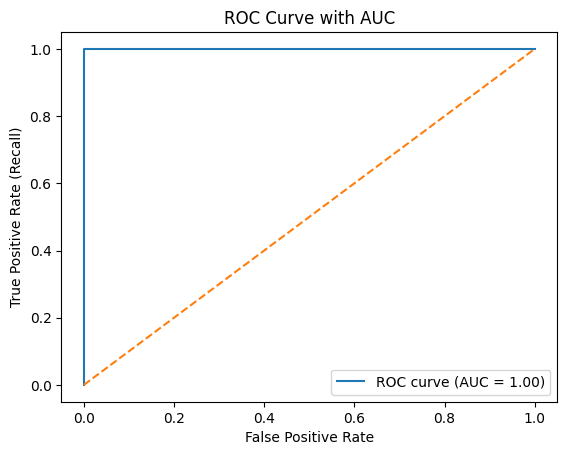

In [ ]:
rf_restrain.plotROC(y_resampled)

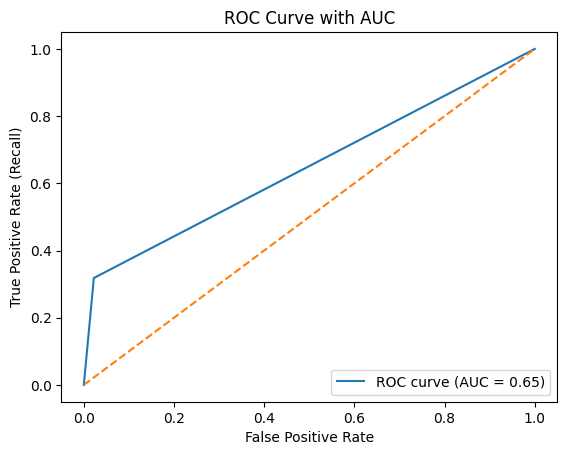

In [ ]:
rf_restest.plotROC(y_test)

# 8. Membandingkan Model

## 8.1 Performa di Data Test

In [ ]:
# Rangkuman Akurasi

print("Accuracy")
print("KNN:", knn_test.accuracy)
print("KNN Resampled:", knn_restest.accuracy)
print("LogReg:", logreg_test.accuracy)
print("LogReg Resampled:", logreg_restest.accuracy)
print("RF:", rf_test.accuracy)
print("RF Resampled:", rf_restest.accuracy)

print("")
print("Recall")
print("KNN:", knn_test.recall)
print("KNN Resampled:", knn_restest.recall)
print("LogReg:", logreg_test.recall)
print("LogReg Resampled:", logreg_restest.recall)
print("RF:", rf_test.recall)
print("RF Resampled:", rf_restest.recall)

print("")
print("AUC")
print("KNN:", knn_test.auc)
print("KNN Resampled:", knn_restest.auc)
print("LogReg:", logreg_test.auc)
print("LogReg Resampled:", logreg_restest.auc)
print("RF:", rf_test.auc)
print("RF Resampled:", rf_restest.auc)


Accuracy
KNN: 0.96
KNN Resampled: 0.87
LogReg: 0.7
LogReg Resampled: 0.72
RF: 0.97
RF Resampled: 0.96

Recall
KNN: 0.02
KNN Resampled: 0.35
LogReg: 0.47
LogReg Resampled: 0.5
RF: 0.12
RF Resampled: 0.32

AUC
KNN: 0.51
KNN Resampled: 0.62
LogReg: 0.59
LogReg Resampled: 0.61
RF: 0.56
RF Resampled: 0.65


Accuracy terbaik adalah RF. Recall terbaik adalah Logreg Resampled. AUC terbaik adalah RF Resampled.

Tidak ada model yang secara konsisten unggul di semua metrik. Pilihan tergantung pada tujuan spesifik dari masalah dan pentingnya masing-masing metrik.

Jika mengidentifikasi kelas positif adalah yang paling penting, maka model LogReg Resampled mungkin merupakan pilihan yang lebih baik karena memiliki recall tertinggi (0.5). Namun, jika akurasi secara umum adalah prioritas, maka model RF bisa menjadi pilihan yang baik karena memiliki akurasi tertinggi (0.97).

In [ ]:
# Menyimpan hasil dalam dictionary
tabel_performa = {
    "Model": ["KNN", "KNN Resampled", "LogReg", "LogReg Resampled", "RF", "RF Resampled"],
    "Accuracy": [knn_test.accuracy, knn_restest.accuracy, logreg_test.accuracy, logreg_restest.accuracy, rf_test.accuracy, rf_restest.accuracy],
    "Recall": [knn_test.recall, knn_restest.recall, logreg_test.recall, logreg_restest.recall, rf_test.recall, rf_restest.recall],
    "AUC": [knn_test.auc, knn_restest.auc, logreg_test.auc, logreg_restest.auc, rf_test.auc, rf_restest.auc]
}

# Membuat DataFrame
df_tabel_performa = pd.DataFrame(tabel_performa)

# Menampilkan DataFrame
print(df_tabel_performa)

              Model  Accuracy  Recall   AUC
0               KNN      0.96    0.02  0.51
1     KNN Resampled      0.87    0.35  0.62
2            LogReg      0.70    0.47  0.59
3  LogReg Resampled      0.72    0.50  0.61
4                RF      0.97    0.12  0.56
5      RF Resampled      0.96    0.32  0.65


In [ ]:
df_tabel_performa.to_excel('df_tabel_performa.xlsx')

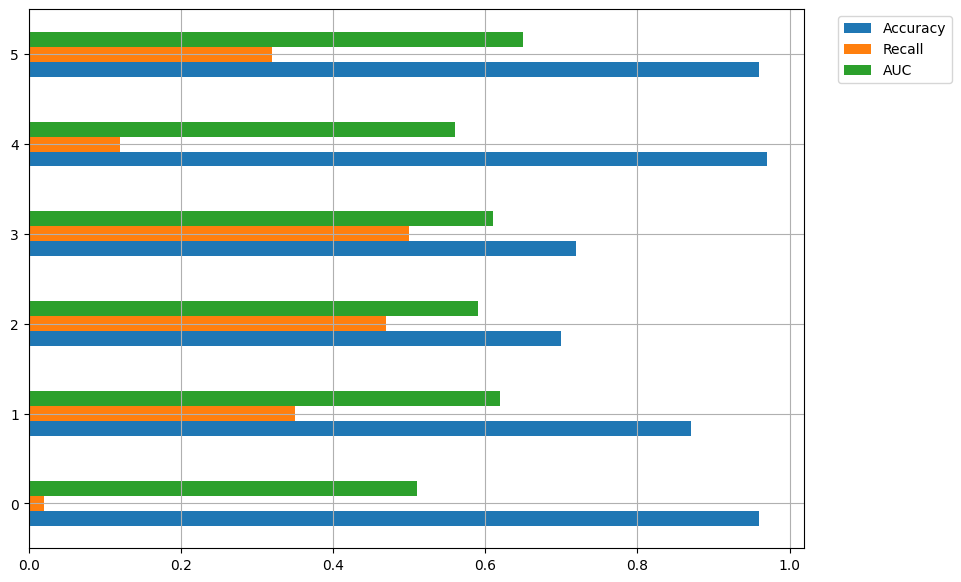

In [ ]:
df_tabel_performa.plot(kind="barh", figsize=(10, 7), grid=True).legend(bbox_to_anchor=(1.2,1));

Prediksi kebangkrutan memiliki konsekuensi finansial atau hukum yang sangat besar (misalnya, dalam pengambilan keputusan investasi atau pemberian pinjaman), maka harus meminimalkan false negatives (mengidentifikasi perusahaan yang sebenarnya bangkrut sebagai tidak bangkrut). Dalam hal ini, recall menjadi metrik yang paling penting. Sehingga LogReg Resampled menjadi model terpilih.
Oleh karena itu dipilih model LogReg Resampled yang dimodelkan dengan data asli (imbalance data).

## 8.2. Performa Model Logistic Regression Resampled

In [ ]:
# Menyimpan hasil dalam dictionary
model_performa = {
    "Data Penguji": ["Data Train", "Data Test"],
    "Accuracy": [logreg_restrain.accuracy, logreg_restest.accuracy],
    "Recall": [logreg_restrain.recall, logreg_restest.recall],
    "AUC": [logreg_restrain.auc, logreg_restest.auc]
}

# Membuat DataFrame
df_model_performa = pd.DataFrame(model_performa)

# Menampilkan DataFrame
print(df_model_performa)

  Data Penguji  Accuracy  Recall   AUC
0   Data Train      0.60    0.46  0.60
1    Data Test      0.72    0.50  0.61


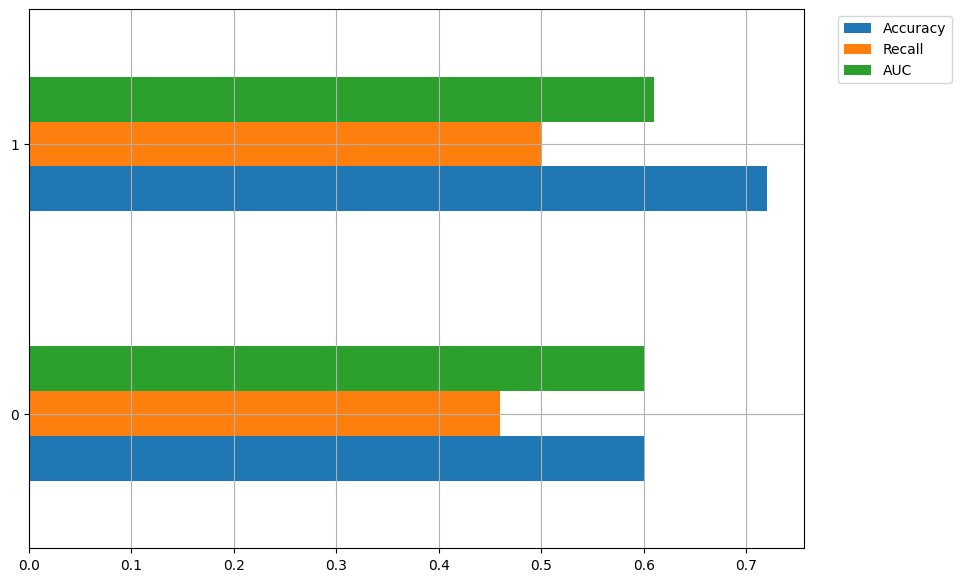

In [ ]:
df_model_performa.plot(kind="barh", figsize=(10, 7), grid=True).legend(bbox_to_anchor=(1.2,1));